In [38]:

import matplotlib
import matplotlib.pyplot as plt
from typing import Tuple
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.metrics import (
    roc_curve, roc_auc_score 
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint

In [2]:
RUTE = Path("../../data").resolve()
FEATURE_FRAME_CSV = RUTE / Path("feature_frame.csv")

In [32]:
feature_frame = pd.read_csv(FEATURE_FRAME_CSV)

In [4]:
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = ["outcome"]

features_cols = [col for col in feature_frame.columns if col not in info_cols + label_col]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]

numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [5]:
def push_relevant_dataframe (df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame: 
    """We are only interested in big enough orders that are profitable"""
    order_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = order_size [order_size >= min_products].index 
    return df.loc[lambda x: x.order_id.isin (orders_of_min_size)]

df = (
    feature_frame.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime (x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

In [6]:
df["outcome"].value_counts(normalize=True)

outcome
0.0    0.985522
1.0    0.014478
Name: proportion, dtype: float64

In [7]:
outcome_frequency_in_orders = df.groupby('order_id')['outcome'].value_counts().unstack(fill_value=0)

outcome_proportion = outcome_frequency_in_orders[0] / outcome_frequency_in_orders[1]

mean_ratio = outcome_proportion.mean()

print(f"The average number of 0 in an order for every 1 is: {mean_ratio}")

The average number of 0 in an order for every 1 is: 83.62571996389401


In [8]:
daily_orders = df.groupby("order_date").order_id.nunique()
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

In [9]:
train_val_cutoff = cumsum_daily_orders [cumsum_daily_orders <= 0.7].idxmax() 
val_test_cutoff = cumsum_daily_orders [cumsum_daily_orders <= 0.9].idxmax()

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


- I make a temporal split due to the change in the business demonstrated in module 3
- By keeping 70% of the orders and not the rows, you ensure that there are no orders left in two different sets, causing data leakage
- You train with 4 months of data, but it is valid with only 18 days, and I test with 9 days.
- Even though you test with so few days, there is no special day at the end of February, and a one-week cycle is also included

In [33]:
train_df = df[df.order_date <= train_val_cutoff]
val_df = df[
    (df.order_date > train_val_cutoff)
    & (df.order_date <= val_test_cutoff)
]
test_df = df[df.order_date > val_test_cutoff]

### Baseline: 
#### Global popularity

In [11]:
def plot_metrics( 
    model_name: str, 
    y_pred: pd.Series, 
    y_test: pd.Series,
    target_precision: float = 0.05,
    figure: Tuple [matplotlib.figure. Figure, np.array] = None,
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred) 
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score (y_test, y_pred)
    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure

    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall Curve")
    ax[0].legend()
    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

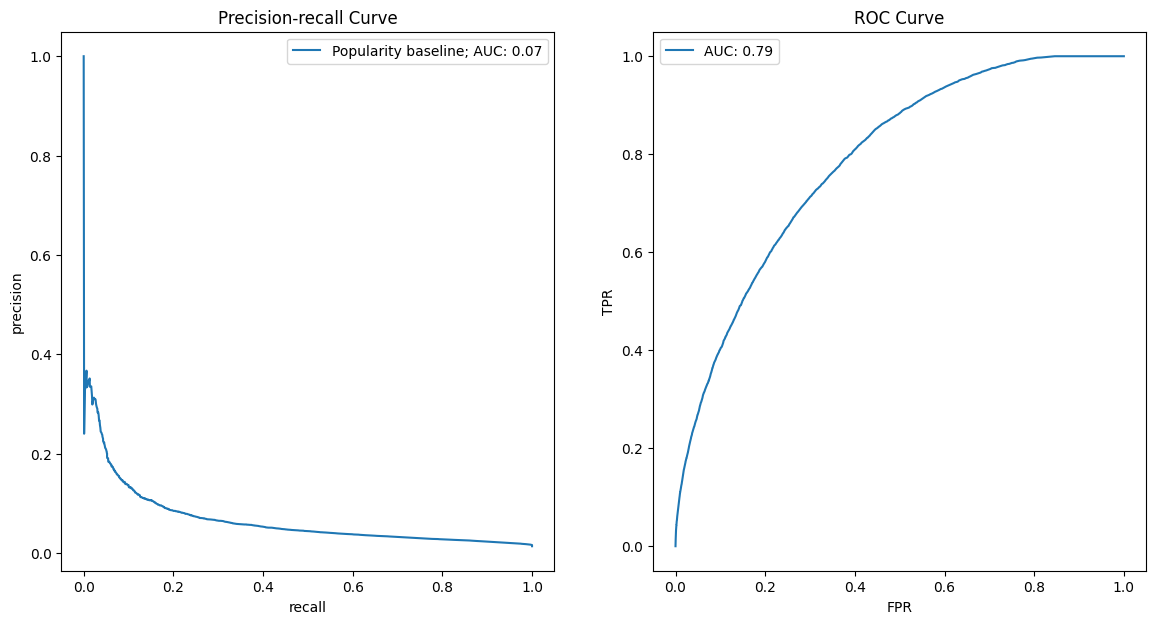

In [12]:
plot_metrics(
    "Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col]
)

- In such unbalanced problems with 98% of the same class, the accuracy will always be very high because you could simply decide that 100% is of that class and you would be 98% correct. However, you wouldn't be predicting anything.
- In these problems it is essential to see the curve to check the operation of the model
- By doing a cross validation with global popularity, a data leakage could be done because you would validate with data from the future in which you would see that the product has more popularity because it has sold a lot

In [34]:
def feature_label_split(df: pd.DataFrame, label_col: str)-> Tuple [pd.DataFrame, pd. Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

y_train_1d = np.ravel(y_train)
y_val_1d = np.ravel(y_val)

#### Linear models

In [14]:
reduced_cols = ["ordered_before", "abandoned_before", "global_popularity", "set_as_regular"]

In [15]:
def get_average_precision_score(
    clf,
    X_train,
    y_train,
    X_val,
    y_val
) -> Tuple[float, float]:
    val_preds = clf.predict_proba(X_val)[:, 1]
    train_preds = clf.predict_proba(X_train)[:, 1]
    
    return average_precision_score(y_train, train_preds), average_precision_score(y_val, val_preds)

In [16]:
lrs_features = [
    {
        "name": "Ridge",
        "c": 1e-6,
        "pipeline": make_pipeline(
            StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)
        ),
    },
    {
        "name": "Lasso",
        "c": 1e-4,
        "pipeline": make_pipeline(
            StandardScaler(), LogisticRegression(penalty="l1", C=1e-4, solver="saga")
        ),
    },

]

for lr in lrs_features:
    lr["pipeline"].fit(X_train[reduced_cols], y_train_1d)

    train_ap, val_ap = get_average_precision_score(
        lr["pipeline"],
        X_train[reduced_cols],
        y_train,
        X_val[reduced_cols],
        y_val,
    )

    print(
        f"{lr['name']} C={lr['c']}. AP train: {train_ap:.4f} and val: {val_ap:.4f}. "
    )

Ridge C=1e-06. AP train: 0.1635 and val: 0.1673. 
Lasso C=0.0001. AP train: 0.1615 and val: 0.1484. 


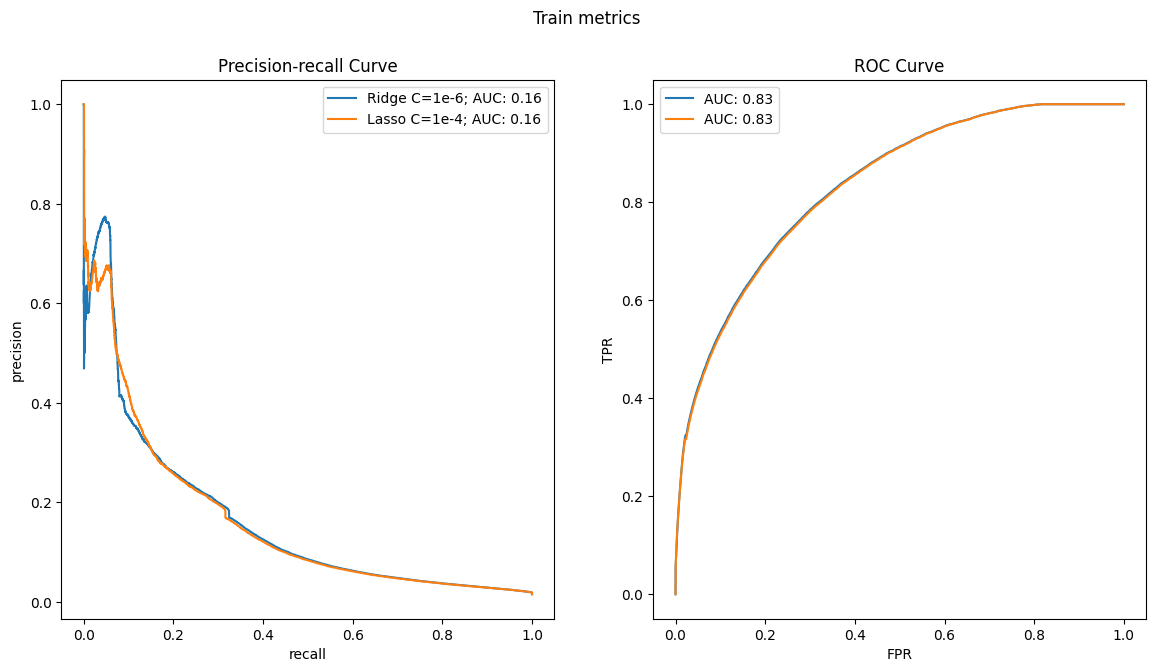

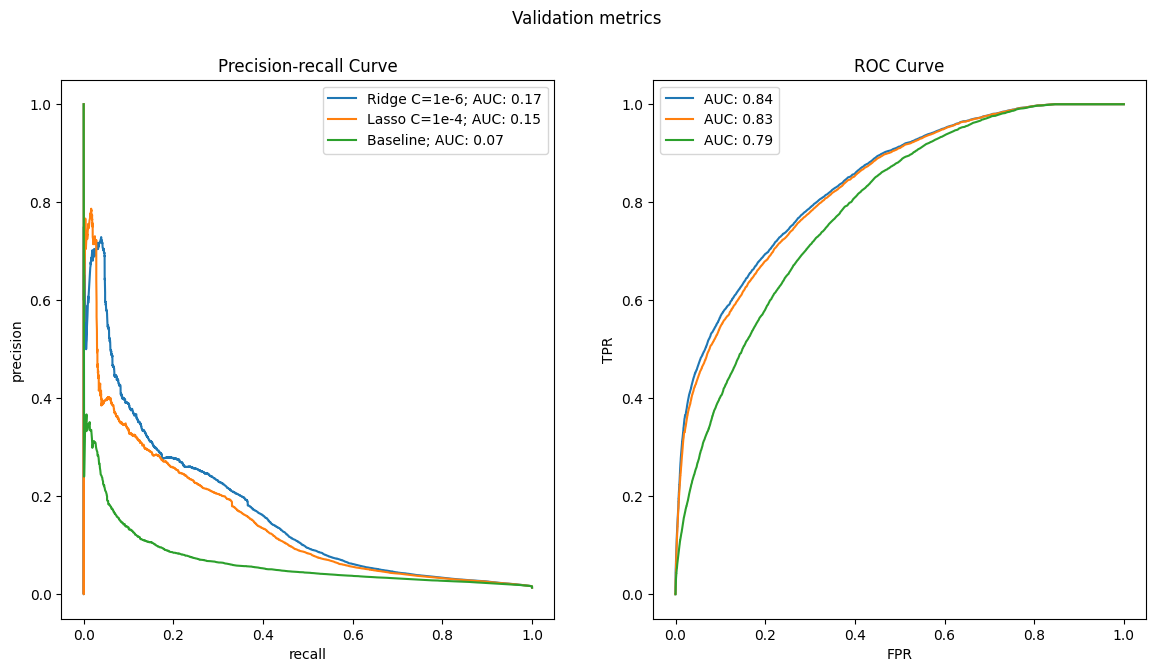

In [17]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)
    ),
    make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=1e-4, solver="saga")
    ),
]

names = ["Ridge C=1e-6", "Lasso C=1e-4"]

for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train_1d)
    train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]

    plot_metrics(
        name, y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]
    
    plot_metrics(name, y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

plot_metrics(
    "Baseline",
    y_pred=val_df["global_popularity"], 
    y_test=val_df[label_col],
    figure=(fig2, ax2),
)

- Having seen the linear metrics and the average precision score, now we are going to try to improve it by using non linear models
- We have to improve a validation average precision score of 0.1673.

### Non linear models

In [19]:
train_cols = numerical_cols + binary_cols

#### Random Forest

In [23]:
n_trees_options = [5, 10, 25, 50, 100]

for n_trees in n_trees_options:
    rf = RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_train[train_cols], y_train_1d)

    train_ap, val_ap = get_average_precision_score(
        rf,
        X_train[train_cols],
        y_train,
        X_val[train_cols],
        y_val,
    )

    print(
        f"Random Forest. Trees: {n_trees}. AP train: {train_ap:.4f} and val: {val_ap:.4f}."
    )

Random Forest. Trees: 5. AP train: 0.7703 and val: 0.0710.
Random Forest. Trees: 10. AP train: 0.8253 and val: 0.0985.
Random Forest. Trees: 25. AP train: 0.8517 and val: 0.1118.
Random Forest. Trees: 50. AP train: 0.8594 and val: 0.1197.
Random Forest. Trees: 100. AP train: 0.8628 and val: 0.1268.


- All random forest with diferent number of estimators are worse than linear models, as we seen that with 100 trees we have a average precision score in validation of 0.1268.
- By adding more trees the model performance only improves a little bit.

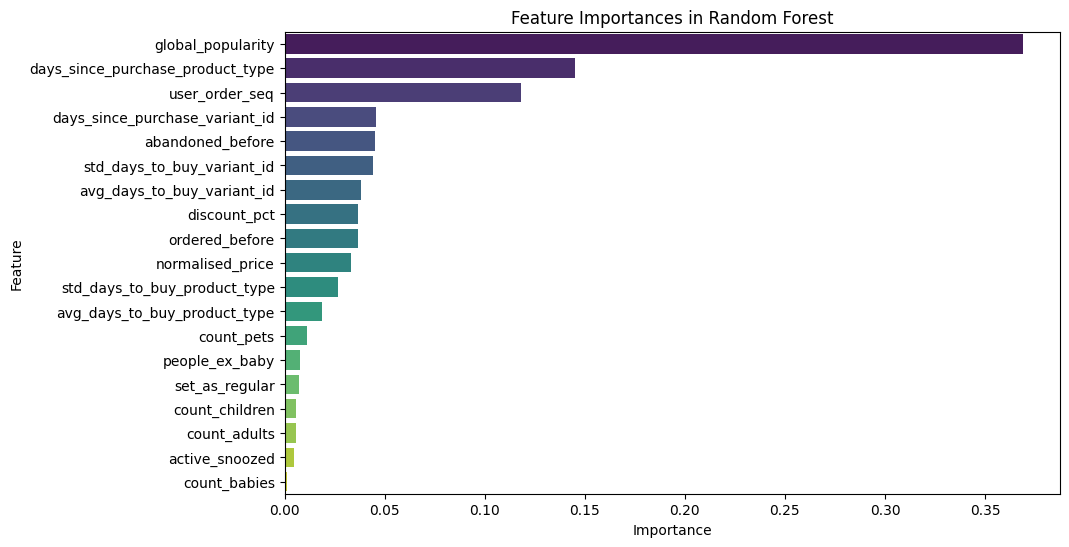

In [25]:
rf = RandomForestClassifier(n_trees_options[len(n_trees_options) - 1])
rf.fit(X_train[train_cols], y_train_1d)

feature_importances = rf.feature_importances_

importances_df = pd.DataFrame({
    'Feature': train_cols,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, hue='Feature', palette='viridis')
plt.title('Feature Importances in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- Only a few columns have a lot of importance. 
- We are going to select the most important columns, although we can lose performance in training.

In [28]:
top_13_features = importances_df.head(13)

top_13_feature_names = top_13_features['Feature'].tolist()

In [29]:
n_trees_options = [5, 10, 25, 50, 100]

for n_trees in n_trees_options:
    rf = RandomForestClassifier(n_estimators=n_trees)
    rf.fit(X_train[top_13_feature_names], y_train_1d)

    train_ap, val_ap = get_average_precision_score(
        rf,
        X_train[top_13_feature_names],
        y_train,
        X_val[top_13_feature_names],
        y_val,
    )

    print(
        f"Random Forest. Trees: {n_trees}. AP train: {train_ap:.4f} and val: {val_ap:.4f}."
    )

Random Forest. Trees: 5. AP train: 0.7616 and val: 0.0689.
Random Forest. Trees: 10. AP train: 0.8155 and val: 0.0830.
Random Forest. Trees: 25. AP train: 0.8440 and val: 0.0980.
Random Forest. Trees: 50. AP train: 0.8514 and val: 0.1060.
Random Forest. Trees: 100. AP train: 0.8546 and val: 0.1112.


- Random forest performance continues to be lower than with linear models.
- We are going to check another non linear models.

#### Gradient boosting trees

In [37]:
lr_options = [0.05, 0.1]
depth_options = [1, 3, 5]
n_trees_options_gbt = [5, 25, 50]

for lr in lr_options:
    for depth in depth_options:
        for n_trees in n_trees_options_gbt:
            gbt = GradientBoostingClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n_trees
            )
            gbt.fit(X_train[train_cols], y_train_1d)

            train_ap, val_ap = get_average_precision_score(
                gbt,
                X_train[train_cols],
                y_train,
                X_val[train_cols],
                y_val,
            )

            print(
                f"Gradient Boosting. Learning rate: {lr}. Max depth: {depth} Trees: {n_trees}. AP train: {train_ap:.4f} and val: {val_ap:.4f}."
            )

Gradient Boosting. Learning rate: 0.05. Max depth: 1 Trees: 5. AP train: 0.0909 and val: 0.0763.
Gradient Boosting. Learning rate: 0.05. Max depth: 1 Trees: 25. AP train: 0.1332 and val: 0.1214.
Gradient Boosting. Learning rate: 0.05. Max depth: 1 Trees: 50. AP train: 0.1554 and val: 0.1418.
Gradient Boosting. Learning rate: 0.05. Max depth: 3 Trees: 5. AP train: 0.1516 and val: 0.1350.
Gradient Boosting. Learning rate: 0.05. Max depth: 3 Trees: 25. AP train: 0.1810 and val: 0.1719.
Gradient Boosting. Learning rate: 0.05. Max depth: 3 Trees: 50. AP train: 0.1902 and val: 0.1864.
Gradient Boosting. Learning rate: 0.05. Max depth: 5 Trees: 5. AP train: 0.1798 and val: 0.1678.
Gradient Boosting. Learning rate: 0.05. Max depth: 5 Trees: 25. AP train: 0.2001 and val: 0.1853.
Gradient Boosting. Learning rate: 0.05. Max depth: 5 Trees: 50. AP train: 0.2099 and val: 0.1923.
Gradient Boosting. Learning rate: 0.1. Max depth: 1 Trees: 5. AP train: 0.0909 and val: 0.0763.
Gradient Boosting. Learni

- As we can see, the best GridSearch Gradient Boosting Tree model is:
    - Learning rate: 0.05
    - Max depth: 5
    - Trees: 50
- The average precision score in validation is 0.1923, which is better than the 0.16 of the linear model

In [46]:
best_lr = 0.05
best_max_depth = 5
best_n_trees = 50

In [ ]:
params = {
    "learning_rate": uniform(0.01, 0.2),  
    "max_depth": randint(1, 6),           
    "n_estimators": randint(5, 51),
}

random_search = RandomizedSearchCV(
    estimator=gbt,
    param_distributions=params,
    n_iter=10,
    scoring="average_precision",
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train[train_cols], y_train_1d)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

print(f"Best parameters: {best_params}")

Best parameters: {'learning_rate': 0.1323705789444759, 'max_depth': 2, 'n_estimators': 32}


- As we can see, the best RandomSearch Gradient Boosting Tree model is:
    - Learning rate: 0.1323705789444759
    - Max depth: 2
    - Trees: 32

In [ ]:
best_lr_in_rs = 0.1323705789444759
best_max_depth_in_rs = 2
best_n_trees_in_rs = 32

gbt = GradientBoostingClassifier(
    learning_rate=best_lr_in_rs, max_depth=best_max_depth_in_rs, n_estimators=best_n_trees_in_rs
)
gbt.fit(X_train[train_cols], y_train_1d)

train_ap, val_ap = get_average_precision_score(
    gbt,
    X_train[train_cols],
    y_train,
    X_val[train_cols],
    y_val,
)

print(
    f"Gradient Boosting. Learning rate: {lr:.4f}. Max depth: {depth} Trees: {n_trees}. AP train: {train_ap:.4f} and val: {val_ap:.4f}."
)

Gradient Boosting. Learning rate: 0.1. Max depth: 5 Trees: 50. AP train: 0.1834 and val: 0.1786.


- The average precision score in validation is 0.1786, which is better than the 0.16 of the linear model, but worse than with GridSearch
- We are trying to improve it by reducing the least important columns

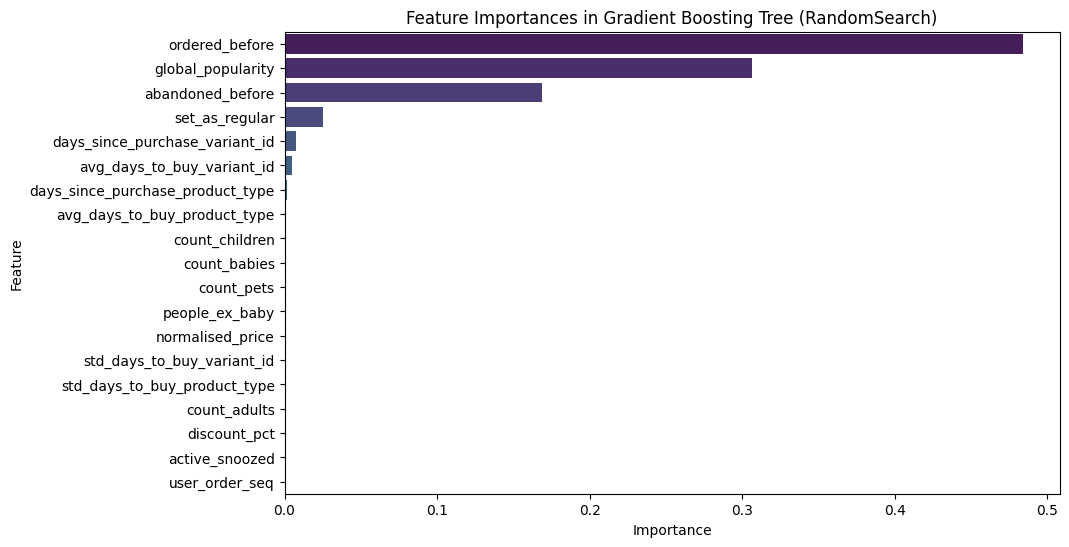

In [41]:
gbt = GradientBoostingClassifier(
    learning_rate=best_lr, max_depth=best_max_depth, n_estimators=best_n_trees
)
gbt.fit(X_train[train_cols], y_train_1d)

feature_importances = gbt.feature_importances_

importances_df = pd.DataFrame({
    'Feature': train_cols,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, hue='Feature', palette='viridis')
plt.title('Feature Importances in Gradient Boosting Tree (RandomSearch)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [42]:
top_4_features = importances_df.head(4)

top_4_feature_names = top_4_features['Feature'].tolist()

In [45]:
gbt = GradientBoostingClassifier(
    learning_rate=best_lr, max_depth=best_max_depth, n_estimators=best_n_trees
)
gbt.fit(X_train[top_4_feature_names], y_train_1d)

train_ap, val_ap = get_average_precision_score(
    gbt,
    X_train[top_4_feature_names],
    y_train,
    X_val[top_4_feature_names],
    y_val,
)

print(
    f"Gradient Boosting with most important features. Learning rate: {lr:.4f}. Max depth: {depth} Trees: {n_trees}. AP train: {train_ap:.4f} and val: {val_ap:.4f}."
)

Gradient Boosting with most important features. Learning rate: 0.1000. Max depth: 5 Trees: 50. AP train: 0.1764 and val: 0.1711.


- The model gets worse when reducing columns

### Comparing models

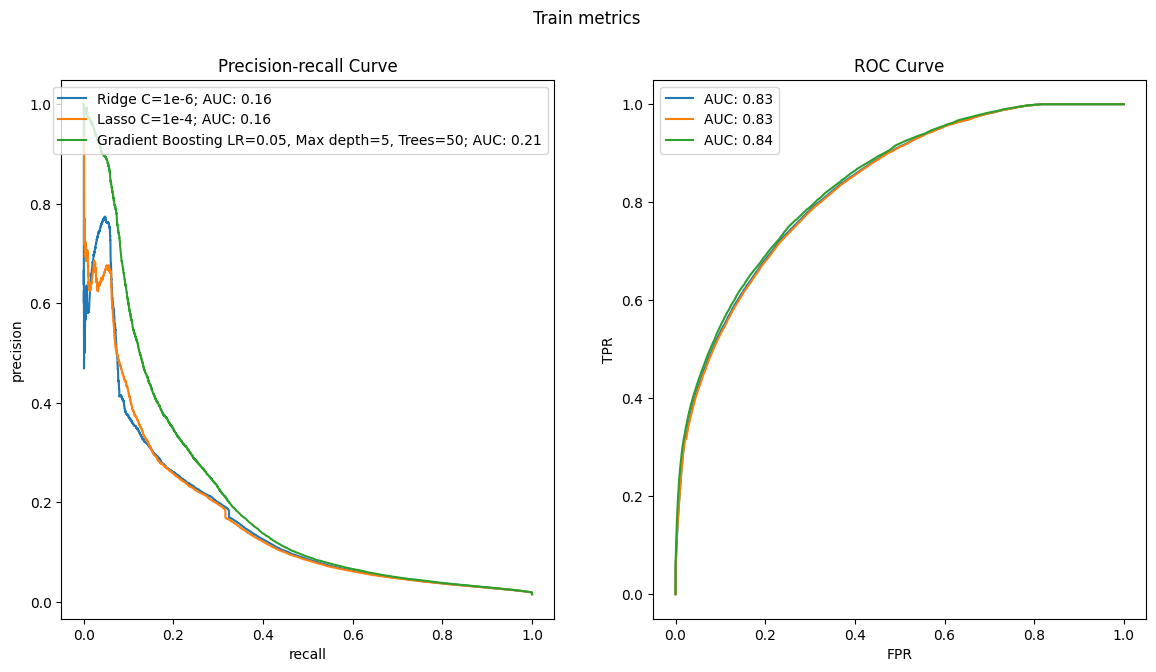

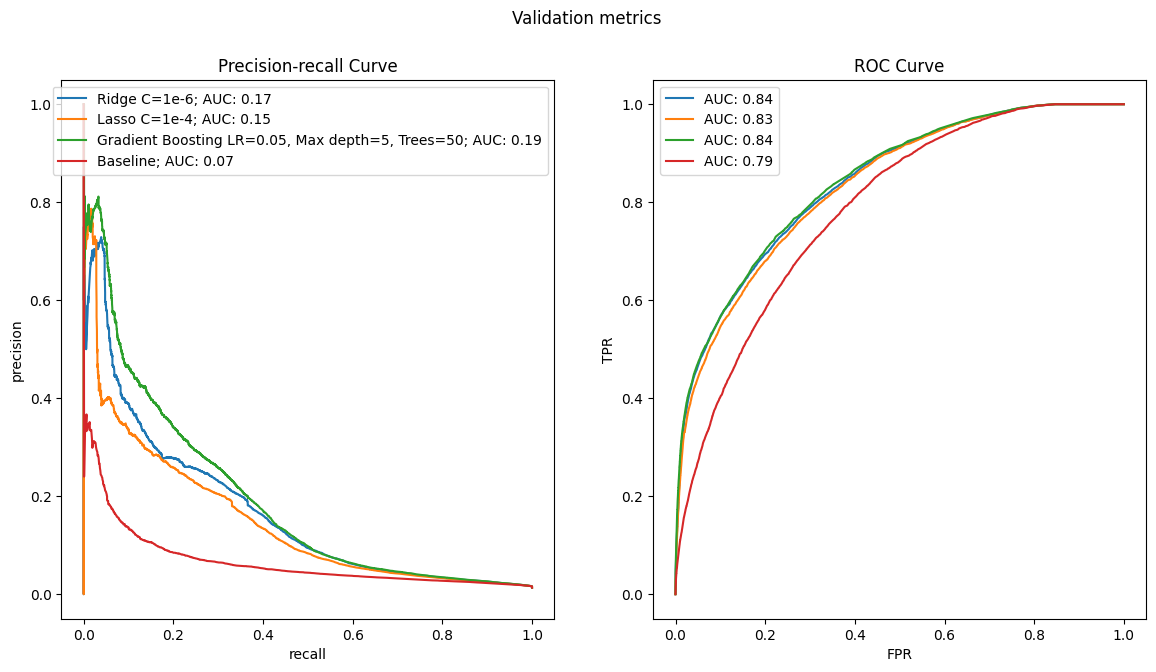

In [48]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

models = [
    make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)
    ),
    make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=1e-4, solver="saga")
    ),
    GradientBoostingClassifier(
        learning_rate=best_lr, max_depth=best_max_depth, n_estimators=best_n_trees
    )  
]

tree_features = train_cols
linear_features = reduced_cols

names = ["Ridge C=1e-6", "Lasso C=1e-4", "Gradient Boosting LR=0.05, Max depth=5, Trees=50"]

for name, model in zip(names, models):
    if isinstance(model, GradientBoostingClassifier):
        selected_cols = tree_features 
    else:
        selected_cols = linear_features
    
    model.fit(X_train[selected_cols], y_train_1d)

    train_proba = model.predict_proba(X_train[selected_cols])[:, 1]

    plot_metrics(
        name, y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = model.predict_proba(X_val[selected_cols])[:, 1]
    
    plot_metrics(name, y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

plot_metrics(
    "Baseline",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    figure=(fig2, ax2),
)

- As we can see in the precision-recall graph, GradientBoosting is the best in every point.
- Nevertheless, the difference between Ridge and GradientBososting in some points is low.
- A linear model is better in performace, so the decision of choosing the model depends on where the business wants to work.
- In all cases, results are much better than the global popularity baseline.